---
# minbpe fun
---

In this repo, we'll be following along with [this video](https://www.youtube.com/watch?v=zduSFxRajkE&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=10) to learn about tokenization! In particular, we'll look at byte-pair encoding tokenization, which was used in the [GPT-2 paper](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf). Tokenization is the process of converting text chunks into tokens, which are the units with which LLMs interact with. Unfortunately, they also cause some strange problems that we'll see later.

---

Tokenization is at the heart of much weirdness of LLMs. Do not brush it off.

- Why can't LLM spell words? **Tokenization**.
- Why can't LLM do super simple string processing tasks like reversing a string? **Tokenization**.
- Why is LLM worse at non-English languages (e.g. Japanese)? **Tokenization**.
- Why is LLM bad at simple arithmetic? **Tokenization**. 
- Why did GPT-2 have more than necessary trouble coding in Python? **Tokenization**.
- Why did my LLM abruptly halt when it sees the string "<|endoftext|>"? **Tokenization**.
- What is this weird warning I get about a "trailing whitespace"? **Tokenization**.
- Why the LLM break if I ask it about "SolidGoldMagikarp"? **Tokenization**.
- Why should I prefer to use YAML over JSON with LLMs? **Tokenization**.
- Why is LLM not actually end-to-end language modeling? **Tokenization**.
- What is the real root of suffering? **Tokenization**.

---

Good tokenization web app: [https://tiktokenizer.vercel.app](https://tiktokenizer.vercel.app)

Plugging the below string into the app above, we find that

- numbers are broken up into multiple tokens

- the word egg has different tokenizations depending on the context
    - "Egg." is a single token at the beginning of a line
    - " Egg" "." are two tokens when at the end of a line
    - "egg" "." are two tokens at the beginning of a line
    - "EG" "G." are two tokens at the beginning of a line

- non-English languages perform slightly worse in ChatGPT because the training set has mainly English
    - the tokenizer datasets are also mainly English, so they also perform worse on non-English languages
    - this results in a higher token counts during tokenization -- fewer groupings of character units because less overall data showing them -- so tokenizer doesn't learn good groupings like in English
    - which bloats up the sequence length of documents, meaning that we're basically stretching out phrases when passing them into the transformer
    - so when contexts are passed in, the token attentions are calculated, but are based on more atomistic tokens
    - whereas in English, we would've passed larger tokens in

- the GPT-2 tokenizer broke up all the spaces (the indent) before a line of code into tokens, making it very wasteful, and making the attention less relevant 
    - so GPT-2 was not very good at coding

- the GPT-4 tokenizer, cl100k_base, tokenizes the strings into about half as many tokens as the GPT-2 tokenizer
    - because the GPT-4 tokenizer has about twice as many tokens in its vocabulary 
    - so the same text is squished into half as many tokens, meaning that the input to the transformer is denser
    - because the context size in attention is fixed (each token has a finite set of tokens it pays attention to before it), we're roughly able to see twice as much text in context
    - increasing the number of tokens does not necessarily improve performance because it ends up increasing the size of the embedding table and the size of the output layer (have to predict the next token)

Example string:

```text
        Tokenization is at the heart of much weirdness of LLMs. Do not brush it off.

        127 + 677 = 804
        1275 + 6773 = 8041

        Egg.
        I have an Egg.
        egg.
        EGG.

        만나서 반가워요. 저는 OpenAI에서 개발한 대규모 언어 모델인 ChatGPT입니다. 궁금한 것이 있으시면 무엇이든 물어보세요.

        for i in range(1, 101):
            if i % 3 == 0 and i % 5 == 0:
                print("FizzBuzz")
            elif i % 3 == 0:
                print("Fizz")
            elif i % 5 == 0:
                print("Buzz")
            else:
                print(i)
```


> Much glory awaits someone who can delete the need for tokenization. But meanwhile, let's learn about it.


---
## 1) Strings in Python

---

In Python, strings are "immutable sequences of [Unicode](https://en.wikipedia.org/wiki/Unicode) code points", which are roughly 150k integers representing characters. 1 Unicode character = 1 code point

In [49]:
"안녕하세요 👋 (hello in Korean!)"

'안녕하세요 👋 (hello in Korean!)'

We can access the code points of each character by using `ord()`.

In [50]:
[ord(x)for x in "안녕하세요 👋 (hello in Korean!)"]

[50504,
 45397,
 54616,
 49464,
 50836,
 32,
 128075,
 32,
 40,
 104,
 101,
 108,
 108,
 111,
 32,
 105,
 110,
 32,
 75,
 111,
 114,
 101,
 97,
 110,
 33,
 41]

We don't want to use these values for tokenization because

1) the Unicode standard is alive and changes
2) there are ~150k code points -- too many
3) these are roughly character level -- at least for English

Unicode text is processed into binary data / byte streams through encoding (UTF-8, UTF-16, and UTF-32). UTF-8 is the most popular and translates the code points into byte streams between 1-4 bytes (UTF-8 and UTF-16 have variable-length encodings). One reason why it's so popular is because it is backwards compatible with ASCII. Some good blogs about UTF-8: [one](https://www.reedbeta.com/blog/programmers-intro-to-unicode/), [two](https://utf8everywhere.org/).

Let's try out encoding the string;.

In [51]:
"안녕하세요 👋 (hello in Korean!)".encode("utf-8")

b'\xec\x95\x88\xeb\x85\x95\xed\x95\x98\xec\x84\xb8\xec\x9a\x94 \xf0\x9f\x91\x8b (hello in Korean!)'

We can convert the bytes object into a list of integers to make it easier to view.

In [52]:
list("안녕하세요 👋 (hello in Korean!)".encode("utf-8"))

[236,
 149,
 136,
 235,
 133,
 149,
 237,
 149,
 152,
 236,
 132,
 184,
 236,
 154,
 148,
 32,
 240,
 159,
 145,
 139,
 32,
 40,
 104,
 101,
 108,
 108,
 111,
 32,
 105,
 110,
 32,
 75,
 111,
 114,
 101,
 97,
 110,
 33,
 41]

But if we were to use these byte streams as vocabulary for our tokenizer, we would only have 256 tokens (1 byte = 8 bits which can encode 0-255). This vocabulary size is way too small!

The embedding table and output layer would be small, just containing 256 rows / neurons corresponding to each token. But all of our text would be stretched out into long sequences of bytes / tokens, and the attention mechanism inside the transformer can only view a fixed context length at a time. So we have small context length and long sequences, which will not allow us to attend to sufficiently long text before us for the purpose of the next-token prediction task. If we want to attend to more bytes, we can increase the context length which is expensive.

So the raw bytes given to us by UTF-8 encoding is not the way to go. There is a [paper](https://arxiv.org/pdf/2305.07185) that does propose a method to do something like this.

For now though, we want to support a larger vocabulary that is tunable as a hyperparameter, while also using UTF encoding. 

Enter BPE... which will allow us to compress the byte sequences into manageable sequences.

---
## 2) Byte pair encoding (BPE)

---

Let's walk through this using the [Wikipedia page](https://en.wikipedia.org/wiki/Byte_pair_encoding). We will iteratively find the pair of tokens that occur the most frequently, and replace them with a single new token, which we then append to our vocabulary.

Suppose the data sequence to be encoded is 

```text
aaabdaaabac
```

which only has 4 elements in the vocabulary {a, b, c, d}. The byte pair "aa" occurs most often, so we mint a new token "Z", and replace every occurrence of "aa" with "Z"

```text
ZabdZabac
```

So now we have a smaller sequence with a vocabulary of 5 tokens {a, b, c, d, Z=aa}. Next, we replace the byte pair "ab" with "Y" (note that "ab" and "Za" both occur twice, but we'll elect to change the literal byte pairs)

```text
ZYdZYac
```

With new vocabulary of 6 tokens {a, b, c, d, Z=aa, Y=ab}. The only literal byte pair left, "ac", only occurs once. We could end here, or create a recursive byte pair (meaning a byte pair containing a byte pair token). In this case, "ZY" occurs twice and can be replaced with "X"

```text
XdXac
```

Giving us a vocabulary of 7 tokens {a, b, c, d, Z=aa, Y=ab, X=ZY}. Now the data cannot be compressed any further by byte pair encoding since there are no pairs of bytes that occur more than once.

So we started out with a byte sequence of length 11 with 4 tokens, and compressed it down to a sequence of length 5 with 7 tokens.

Cool! Next we can apply this to our actual byte stream (byte meaning byte, not letter :) ) from before. 

We'll start out with our byte sequences and a 256 vocab size (1 byte encodes 256 values). We'll iteratively go through these and find the byte pairs that occur the most, mint new tokens, append them to our vocabulary, and replace them in the sequence. In this way, we'll end up with a compressed training set.

We see below that the encoded byte stream is actually greater than the number of code points / characters in the text. Remember, this is because UTF-8 uses up to 4 bytes to encode a single code point, especially for the more complex Unicode characters.

In [53]:
# text from https://www.reedbeta.com/blog/programmers-intro-to-unicode/
text = "Ｕｎｉｃｏｄｅ! 🅤🅝🅘🅒🅞🅓🅔‽ 🇺‌🇳‌🇮‌🇨‌🇴‌🇩‌🇪! 😄 The very name strikes fear and awe into the hearts of programmers worldwide. We all know we ought to “support Unicode” in our software (whatever that means—like using wchar_t for all the strings, right?). But Unicode can be abstruse, and diving into the thousand-page Unicode Standard plus its dozens of supplementary annexes, reports, and notes can be more than a little intimidating. I don’t blame programmers for still finding the whole thing mysterious, even 30 years after Unicode’s inception."
tokens = text.encode("utf-8")   # raw bytes
tokens = list(map(int, tokens)) # convert to a list of integers in range 0..255 for convenience
print('---')
print(text)
print("character / code point length:", len(text))
print('---')
print(tokens)
print("encoded byte length:", len(tokens))

---
Ｕｎｉｃｏｄｅ! 🅤🅝🅘🅒🅞🅓🅔‽ 🇺‌🇳‌🇮‌🇨‌🇴‌🇩‌🇪! 😄 The very name strikes fear and awe into the hearts of programmers worldwide. We all know we ought to “support Unicode” in our software (whatever that means—like using wchar_t for all the strings, right?). But Unicode can be abstruse, and diving into the thousand-page Unicode Standard plus its dozens of supplementary annexes, reports, and notes can be more than a little intimidating. I don’t blame programmers for still finding the whole thing mysterious, even 30 years after Unicode’s inception.
character / code point length: 533
---
[239, 188, 181, 239, 189, 142, 239, 189, 137, 239, 189, 131, 239, 189, 143, 239, 189, 132, 239, 189, 133, 33, 32, 240, 159, 133, 164, 240, 159, 133, 157, 240, 159, 133, 152, 240, 159, 133, 146, 240, 159, 133, 158, 240, 159, 133, 147, 240, 159, 133, 148, 226, 128, 189, 32, 240, 159, 135, 186, 226, 128, 140, 240, 159, 135, 179, 226, 128, 140, 240, 159, 135, 174, 226, 128, 140, 240, 159, 135, 168, 226, 128, 140, 240, 159, 

In [54]:
def get_stats(ids):
    counts = {}
    for pair in zip(ids, ids[1:]):
        counts[pair] = counts.get(pair, 0) + 1
    return counts

In [55]:
stats = get_stats(tokens)
print(stats)
print(sorted(((v, k) for k, v in stats.items()), reverse=True)) # sorting a value-key list [(v, k), (v, k), ...]

{(239, 188): 1, (188, 181): 1, (181, 239): 1, (239, 189): 6, (189, 142): 1, (142, 239): 1, (189, 137): 1, (137, 239): 1, (189, 131): 1, (131, 239): 1, (189, 143): 1, (143, 239): 1, (189, 132): 1, (132, 239): 1, (189, 133): 1, (133, 33): 1, (33, 32): 2, (32, 240): 3, (240, 159): 15, (159, 133): 7, (133, 164): 1, (164, 240): 1, (133, 157): 1, (157, 240): 1, (133, 152): 1, (152, 240): 1, (133, 146): 1, (146, 240): 1, (133, 158): 1, (158, 240): 1, (133, 147): 1, (147, 240): 1, (133, 148): 1, (148, 226): 1, (226, 128): 12, (128, 189): 1, (189, 32): 1, (159, 135): 7, (135, 186): 1, (186, 226): 1, (128, 140): 6, (140, 240): 6, (135, 179): 1, (179, 226): 1, (135, 174): 1, (174, 226): 1, (135, 168): 1, (168, 226): 1, (135, 180): 1, (180, 226): 1, (135, 169): 1, (169, 226): 1, (135, 170): 1, (170, 33): 1, (159, 152): 1, (152, 132): 1, (132, 32): 1, (32, 84): 1, (84, 104): 1, (104, 101): 6, (101, 32): 20, (32, 118): 1, (118, 101): 3, (101, 114): 6, (114, 121): 2, (121, 32): 2, (32, 110): 2, (110,

We can use `chr`, the opposite of `ord`, to decode the most frequent pair (101, 32) to see what it is. It turns out to be ("e", " "), meaning that there are a lot of words that end with "e".

In [56]:
chr(101), chr(32)

('e', ' ')

Now let's start minting and replacing tokens.

In [57]:
# since stats is a dict, the provided key .get calls stats[idx] = freq_count (ranks based on frequency)
top_pair = max(stats, key=stats.get)
top_pair

(101, 32)

In [58]:
def merge(ids: list[int], pair: tuple[int], idx: int) -> list[int]:
    """in the list of ints (ids), replace all consecutive occurrences of pair with the new token idx"""
    newids: list[int] = []
    i = 0
    while i < len(ids):
        # if we are not at the very last position AND the pair matches, replace it
        if i < len(ids) - 1 and ids[i] == pair[0] and ids[i+1] == pair[1]:
            newids.append(idx) # add new idx instead of the pair (replace the old two ints)
            i += 2
        # otherwise, only proceed one step to check next pair
        else:
            newids.append(ids[i])
            i += 1
    return newids

print(merge([5, 6, 6, 7, 9, 1], (6, 7), 99))

[5, 6, 99, 9, 1]


We previously had a sequence of 616 bytes and a vocab of size 256. This meant that we had integer encodings between 0 and 255. Now we want to use our `merge()` function to replace our `top_pair` of (101, 32) with a new token `idx` 256 (1 above the previous highest, 255). We can pass in the original 616-length byte stream `tokens`, and find that our new byte stream `tokens2` has been compressed down to 596 tokens. In addition, we should now find no occurrences of (101, 32) within `tokens2`, as all instances have been replaced with 256.

In [59]:
tokens2 = merge(tokens, top_pair, 256)
print(tokens2)
print("length:", len(tokens2))

[239, 188, 181, 239, 189, 142, 239, 189, 137, 239, 189, 131, 239, 189, 143, 239, 189, 132, 239, 189, 133, 33, 32, 240, 159, 133, 164, 240, 159, 133, 157, 240, 159, 133, 152, 240, 159, 133, 146, 240, 159, 133, 158, 240, 159, 133, 147, 240, 159, 133, 148, 226, 128, 189, 32, 240, 159, 135, 186, 226, 128, 140, 240, 159, 135, 179, 226, 128, 140, 240, 159, 135, 174, 226, 128, 140, 240, 159, 135, 168, 226, 128, 140, 240, 159, 135, 180, 226, 128, 140, 240, 159, 135, 169, 226, 128, 140, 240, 159, 135, 170, 33, 32, 240, 159, 152, 132, 32, 84, 104, 256, 118, 101, 114, 121, 32, 110, 97, 109, 256, 115, 116, 114, 105, 107, 101, 115, 32, 102, 101, 97, 114, 32, 97, 110, 100, 32, 97, 119, 256, 105, 110, 116, 111, 32, 116, 104, 256, 104, 101, 97, 114, 116, 115, 32, 111, 102, 32, 112, 114, 111, 103, 114, 97, 109, 109, 101, 114, 115, 32, 119, 111, 114, 108, 100, 119, 105, 100, 101, 46, 32, 87, 256, 97, 108, 108, 32, 107, 110, 111, 119, 32, 119, 256, 111, 117, 103, 104, 116, 32, 116, 111, 32, 226, 128, 156

Now we can write a while loop to do this iteratively for us. The more steps we take, the larger the vocabulary will be, and the shorter our sequence will be. There is some sweet spot that works best in practice and is a hyperparameter.

But first, we'll take all of the text from the blog post to make a larger, more representative training set for the tokenizer.

In [60]:
# using all the text from the blog post now
# making the training text longer to have more representative token statistics
# text from https://www.reedbeta.com/blog/programmers-intro-to-unicode/
text = """A Programmer’s Introduction to Unicode March 3, 2017 · Coding · 22 Comments  Ｕｎｉｃｏｄｅ! 🅤🅝🅘🅒🅞🅓🅔‽ 🇺\u200c🇳\u200c🇮\u200c🇨\u200c🇴\u200c🇩\u200c🇪! 😄 The very name strikes fear and awe into the hearts of programmers worldwide. We all know we ought to “support Unicode” in our software (whatever that means—like using wchar_t for all the strings, right?). But Unicode can be abstruse, and diving into the thousand-page Unicode Standard plus its dozens of supplementary annexes, reports, and notes can be more than a little intimidating. I don’t blame programmers for still finding the whole thing mysterious, even 30 years after Unicode’s inception.  A few months ago, I got interested in Unicode and decided to spend some time learning more about it in detail. In this article, I’ll give an introduction to it from a programmer’s point of view.  I’m going to focus on the character set and what’s involved in working with strings and files of Unicode text. However, in this article I’m not going to talk about fonts, text layout/shaping/rendering, or localization in detail—those are separate issues, beyond my scope (and knowledge) here.  Diversity and Inherent Complexity The Unicode Codespace Codespace Allocation Scripts Usage Frequency Encodings UTF-8 UTF-16 Combining Marks Canonical Equivalence Normalization Forms Grapheme Clusters And More… Diversity and Inherent Complexity As soon as you start to study Unicode, it becomes clear that it represents a large jump in complexity over character sets like ASCII that you may be more familiar with. It’s not just that Unicode contains a much larger number of characters, although that’s part of it. Unicode also has a great deal of internal structure, features, and special cases, making it much more than what one might expect a mere “character set” to be. We’ll see some of that later in this article.  When confronting all this complexity, especially as an engineer, it’s hard not to find oneself asking, “Why do we need all this? Is this really necessary? Couldn’t it be simplified?”  However, Unicode aims to faithfully represent the entire world’s writing systems. The Unicode Consortium’s stated goal is “enabling people around the world to use computers in any language”. And as you might imagine, the diversity of written languages is immense! To date, Unicode supports 135 different scripts, covering some 1100 languages, and there’s still a long tail of over 100 unsupported scripts, both modern and historical, which people are still working to add.  Given this enormous diversity, it’s inevitable that representing it is a complicated project. Unicode embraces that diversity, and accepts the complexity inherent in its mission to include all human writing systems. It doesn’t make a lot of trade-offs in the name of simplification, and it makes exceptions to its own rules where necessary to further its mission.  Moreover, Unicode is committed not just to supporting texts in any single language, but also to letting multiple languages coexist within one text—which introduces even more complexity.  Most programming languages have libraries available to handle the gory low-level details of text manipulation, but as a programmer, you’ll still need to know about certain Unicode features in order to know when and how to apply them. It may take some time to wrap your head around it all, but don’t be discouraged—think about the billions of people for whom your software will be more accessible through supporting text in their language. Embrace the complexity!  The Unicode Codespace Let’s start with some general orientation. The basic elements of Unicode—its “characters”, although that term isn’t quite right—are called code points. Code points are identified by number, customarily written in hexadecimal with the prefix “U+”, such as U+0041 “A” latin capital letter a or U+03B8 “θ” greek small letter theta. Each code point also has a short name, and quite a few other properties, specified in the Unicode Character Database.  The set of all possible code points is called the codespace. The Unicode codespace consists of 1,114,112 code points. However, only 128,237 of them—about 12% of the codespace—are actually assigned, to date. There’s plenty of room for growth! Unicode also reserves an additional 137,468 code points as “private use” areas, which have no standardized meaning and are available for individual applications to define for their own purposes.  Codespace Allocation To get a feel for how the codespace is laid out, it’s helpful to visualize it. Below is a map of the entire codespace, with one pixel per code point. It’s arranged in tiles for visual coherence; each small square is 16×16 = 256 code points, and each large square is a “plane” of 65,536 code points. There are 17 planes altogether.  Map of the Unicode codespace (click to zoom)  White represents unassigned space. Blue is assigned code points, green is private-use areas, and the small red area is surrogates (more about those later). As you can see, the assigned code points are distributed somewhat sparsely, but concentrated in the first three planes.  Plane 0 is also known as the “Basic Multilingual Plane”, or BMP. The BMP contains essentially all the characters needed for modern text in any script, including Latin, Cyrillic, Greek, Han (Chinese), Japanese, Korean, Arabic, Hebrew, Devanagari (Indian), and many more.  (In the past, the codespace was just the BMP and no more—Unicode was originally conceived as a straightforward 16-bit encoding, with only 65,536 code points. It was expanded to its current size in 1996. However, the vast majority of code points in modern text belong to the BMP.)  Plane 1 contains historical scripts, such as Sumerian cuneiform and Egyptian hieroglyphs, as well as emoji and various other symbols. Plane 2 contains a large block of less-common and historical Han characters. The remaining planes are empty, except for a small number of rarely-used formatting characters in Plane 14; planes 15–16 are reserved entirely for private use.  Scripts Let’s zoom in on the first three planes, since that’s where the action is:  Map of scripts in Unicode planes 0–2 (click to zoom)  This map color-codes the 135 different scripts in Unicode. You can see how Han () and Korean () take up most of the range of the BMP (the left large square). By contrast, all of the European, Middle Eastern, and South Asian scripts fit into the first row of the BMP in this diagram.  Many areas of the codespace are adapted or copied from earlier encodings. For example, the first 128 code points of Unicode are just a copy of ASCII. This has clear benefits for compatibility—it’s easy to losslessly convert texts from smaller encodings into Unicode (and the other direction too, as long as no characters outside the smaller encoding are used).  Usage Frequency One more interesting way to visualize the codespace is to look at the distribution of usage—in other words, how often each code point is actually used in real-world texts. Below is a heat map of planes 0–2 based on a large sample of text from Wikipedia and Twitter (all languages). Frequency increases from black (never seen) through red and yellow to white.  Heat map of code point usage frequency in Unicode planes 0–2 (click to zoom)  You can see that the vast majority of this text sample lies in the BMP, with only scattered usage of code points from planes 1–2. The biggest exception is emoji, which show up here as the several bright squares in the bottom row of plane 1.  Encodings We’ve seen that Unicode code points are abstractly identified by their index in the codespace, ranging from U+0000 to U+10FFFF. But how do code points get represented as bytes, in memory or in a file?  The most convenient, computer-friendliest (and programmer-friendliest) thing to do would be to just store the code point index as a 32-bit integer. This works, but it consumes 4 bytes per code point, which is sort of a lot. Using 32-bit ints for Unicode will cost you a bunch of extra storage, memory, and performance in bandwidth-bound scenarios, if you work with a lot of text.  Consequently, there are several more-compact encodings for Unicode. The 32-bit integer encoding is officially called UTF-32 (UTF = “Unicode Transformation Format”), but it’s rarely used for storage. At most, it comes up sometimes as a temporary internal representation, for examining or operating on the code points in a string.  Much more commonly, you’ll see Unicode text encoded as either UTF-8 or UTF-16. These are both variable-length encodings, made up of 8-bit or 16-bit units, respectively. In these schemes, code points with smaller index values take up fewer bytes, which saves a lot of memory for typical texts. The trade-off is that processing UTF-8/16 texts is more programmatically involved, and likely slower.  UTF-8 In UTF-8, each code point is stored using 1 to 4 bytes, based on its index value.  UTF-8 uses a system of binary prefixes, in which the high bits of each byte mark whether it’s a single byte, the beginning of a multi-byte sequence, or a continuation byte; the remaining bits, concatenated, give the code point index. This table shows how it works:  UTF-8 (binary)\tCode point (binary)\tRange 0xxxxxxx\txxxxxxx\tU+0000–U+007F 110xxxxx 10yyyyyy\txxxxxyyyyyy\tU+0080–U+07FF 1110xxxx 10yyyyyy 10zzzzzz\txxxxyyyyyyzzzzzz\tU+0800–U+FFFF 11110xxx 10yyyyyy 10zzzzzz 10wwwwww\txxxyyyyyyzzzzzzwwwwww\tU+10000–U+10FFFF A handy property of UTF-8 is that code points below 128 (ASCII characters) are encoded as single bytes, and all non-ASCII code points are encoded using sequences of bytes 128–255. This has a couple of nice consequences. First, any strings or files out there that are already in ASCII can also be interpreted as UTF-8 without any conversion. Second, lots of widely-used string programming idioms—such as null termination, or delimiters (newlines, tabs, commas, slashes, etc.)—will just work on UTF-8 strings. ASCII bytes never occur inside the encoding of non-ASCII code points, so searching byte-wise for a null terminator or a delimiter will do the right thing.  Thanks to this convenience, it’s relatively simple to extend legacy ASCII programs and APIs to handle UTF-8 strings. UTF-8 is very widely used in the Unix/Linux and Web worlds, and many programmers argue UTF-8 should be the default encoding everywhere.  However, UTF-8 isn’t a drop-in replacement for ASCII strings in all respects. For instance, code that iterates over the “characters” in a string will need to decode UTF-8 and iterate over code points (or maybe grapheme clusters—more about those later), not bytes. When you measure the “length” of a string, you’ll need to think about whether you want the length in bytes, the length in code points, the width of the text when rendered, or something else.  UTF-16 The other encoding that you’re likely to encounter is UTF-16. It uses 16-bit words, with each code point stored as either 1 or 2 words.  Like UTF-8, we can express the UTF-16 encoding rules in the form of binary prefixes:  UTF-16 (binary)\tCode point (binary)\tRange xxxxxxxxxxxxxxxx\txxxxxxxxxxxxxxxx\tU+0000–U+FFFF 110110xxxxxxxxxx 110111yyyyyyyyyy\txxxxxxxxxxyyyyyyyyyy + 0x10000\tU+10000–U+10FFFF A more common way that people talk about UTF-16 encoding, though, is in terms of code points called “surrogates”. All the code points in the range U+D800–U+DFFF—or in other words, the code points that match the binary prefixes 110110 and 110111 in the table above—are reserved specifically for UTF-16 encoding, and don’t represent any valid characters on their own. They’re only meant to occur in the 2-word encoding pattern above, which is called a “surrogate pair”. Surrogate code points are illegal in any other context! They’re not allowed in UTF-8 or UTF-32 at all.  Historically, UTF-16 is a descendant of the original, pre-1996 versions of Unicode, in which there were only 65,536 code points. The original intention was that there would be no different “encodings”; Unicode was supposed to be a straightforward 16-bit character set. Later, the codespace was expanded to make room for a long tail of less-common (but still important) Han characters, which the Unicode designers didn’t originally plan for. Surrogates were then introduced, as—to put it bluntly—a kludge, allowing 16-bit encodings to access the new code points.  Today, Javascript uses UTF-16 as its standard string representation: if you ask for the length of a string, or iterate over it, etc., the result will be in UTF-16 words, with any code points outside the BMP expressed as surrogate pairs. UTF-16 is also used by the Microsoft Win32 APIs; though Win32 supports either 8-bit or 16-bit strings, the 8-bit version unaccountably still doesn’t support UTF-8—only legacy code-page encodings, like ANSI. This leaves UTF-16 as the only way to get proper Unicode support in Windows. (Update: in Win10 version 1903, they finally added UTF-8 support to the 8-bit APIs! 😊)  By the way, UTF-16’s words can be stored either little-endian or big-endian. Unicode has no opinion on that issue, though it does encourage the convention of putting U+FEFF zero width no-break space at the top of a UTF-16 file as a byte-order mark, to disambiguate the endianness. (If the file doesn’t match the system’s endianness, the BOM will be decoded as U+FFFE, which isn’t a valid code point.)  Combining Marks In the story so far, we’ve been focusing on code points. But in Unicode, a “character” can be more complicated than just an individual code point!  Unicode includes a system for dynamically composing characters, by combining multiple code points together. This is used in various ways to gain flexibility without causing a huge combinatorial explosion in the number of code points.  In European languages, for example, this shows up in the application of diacritics to letters. Unicode supports a wide range of diacritics, including acute and grave accents, umlauts, cedillas, and many more. All these diacritics can be applied to any letter of any alphabet—and in fact, multiple diacritics can be used on a single letter.  If Unicode tried to assign a distinct code point to every possible combination of letter and diacritics, things would rapidly get out of hand. Instead, the dynamic composition system enables you to construct the character you want, by starting with a base code point (the letter) and appending additional code points, called “combining marks”, to specify the diacritics. When a text renderer sees a sequence like this in a string, it automatically stacks the diacritics over or under the base letter to create a composed character.  For example, the accented character “Á” can be expressed as a string of two code points: U+0041 “A” latin capital letter a plus U+0301 “◌́” combining acute accent. This string automatically gets rendered as a single character: “Á”.  Now, Unicode does also include many “precomposed” code points, each representing a letter with some combination of diacritics already applied, such as U+00C1 “Á” latin capital letter a with acute or U+1EC7 “ệ” latin small letter e with circumflex and dot below. I suspect these are mostly inherited from older encodings that were assimilated into Unicode, and kept around for compatibility. In practice, there are precomposed code points for most of the common letter-with-diacritic combinations in European-script languages, so they don’t use dynamic composition that much in typical text.  Still, the system of combining marks does allow for an arbitrary number of diacritics to be stacked on any base character. The reductio-ad-absurdum of this is Zalgo text, which works by ͖͟ͅr͞aṋ̫̠̖͈̗d͖̻̹óm̪͙͕̗̝ļ͇̰͓̳̫ý͓̥̟͍ ̕s̫t̫̱͕̗̰̼̘͜a̼̩͖͇̠͈̣͝c̙͍k̖̱̹͍͘i̢n̨̺̝͇͇̟͙ģ̫̮͎̻̟ͅ ̕n̼̺͈͞u̮͙m̺̭̟̗͞e̞͓̰̤͓̫r̵o̖ṷs҉̪͍̭̬̝̤ ̮͉̝̞̗̟͠d̴̟̜̱͕͚i͇̫̼̯̭̜͡ḁ͙̻̼c̲̲̹r̨̠̹̣̰̦i̱t̤̻̤͍͙̘̕i̵̜̭̤̱͎c̵s ͘o̱̲͈̙͖͇̲͢n͘ ̜͈e̬̲̠̩ac͕̺̠͉h̷̪ ̺̣͖̱ḻ̫̬̝̹ḙ̙̺͙̭͓̲t̞̞͇̲͉͍t̷͔̪͉̲̻̠͙e̦̻͈͉͇r͇̭̭̬͖,̖́ ̜͙͓̣̭s̘̘͈o̱̰̤̲ͅ ̛̬̜̙t̼̦͕̱̹͕̥h̳̲͈͝ͅa̦t̻̲ ̻̟̭̦̖t̛̰̩h̠͕̳̝̫͕e͈̤̘͖̞͘y҉̝͙ ̷͉͔̰̠o̞̰v͈͈̳̘͜er̶f̰͈͔ḻ͕̘̫̺̲o̲̭͙͠ͅw̱̳̺ ͜t̸h͇̭͕̳͍e̖̯̟̠ ͍̞̜͔̩̪͜ļ͎̪̲͚i̝̲̹̙̩̹n̨̦̩̖ḙ̼̲̼͢ͅ ̬͝s̼͚̘̞͝p͙̘̻a̙c҉͉̜̤͈̯̖i̥͡n̦̠̱͟g̸̗̻̦̭̮̟ͅ ̳̪̠͖̳̯̕a̫͜n͝d͡ ̣̦̙ͅc̪̗r̴͙̮̦̹̳e͇͚̞͔̹̫͟a̙̺̙ț͔͎̘̹ͅe̥̩͍ a͖̪̜̮͙̹n̢͉̝ ͇͉͓̦̼́a̳͖̪̤̱p̖͔͔̟͇͎͠p̱͍̺ę̲͎͈̰̲̤̫a̯͜r̨̮̫̣̘a̩̯͖n̹̦̰͎̣̞̞c̨̦̱͔͎͍͖e̬͓͘ ̤̰̩͙̤̬͙o̵̼̻̬̻͇̮̪f̴ ̡̙̭͓͖̪̤“̸͙̠̼c̳̗͜o͏̼͙͔̮r̞̫̺̞̥̬ru̺̻̯͉̭̻̯p̰̥͓̣̫̙̤͢t̳͍̳̖ͅi̶͈̝͙̼̙̹o̡͔n̙̺̹̖̩͝ͅ”̨̗͖͚̩.̯͓  A few other places where dynamic character composition shows up in Unicode:  Vowel-pointing notation in Arabic and Hebrew. In these languages, words are normally spelled with some of their vowels left out. They then have diacritic notation to indicate the vowels (used in dictionaries, language-teaching materials, children’s books, and such). These diacritics are expressed with combining marks.  A Hebrew example, with niqqud:\tאֶת דַלְתִּי הֵזִיז הֵנִיעַ, קֶטֶב לִשְׁכַּתִּי יָשׁוֹד Normal writing (no niqqud):\tאת דלתי הזיז הניע, קטב לשכתי ישוד Devanagari, the script used to write Hindi, Sanskrit, and many other South Asian languages, expresses certain vowels as combining marks attached to consonant letters. For example, “ह” + “\u200bि” = “हि” (“h” + “i” = “hi”). Korean characters stand for syllables, but they are composed of letters called jamo that stand for the vowels and consonants in the syllable. While there are code points for precomposed Korean syllables, it’s also possible to dynamically compose them by concatenating their jamo. For example, “ᄒ” + “ᅡ” + “ᆫ” = “한” (“h” + “a” + “n” = “han”). Canonical Equivalence In Unicode, precomposed characters exist alongside the dynamic composition system. A consequence of this is that there are multiple ways to express “the same” string—different sequences of code points that result in the same user-perceived characters. For example, as we saw earlier, we can express the character “Á” either as the single code point U+00C1, or as the string of two code points U+0041 U+0301.  Another source of ambiguity is the ordering of multiple diacritics in a single character. Diacritic order matters visually when two diacritics apply to the same side of the base character, e.g. both above: “ǡ” (dot, then macron) is different from “ā̇” (macron, then dot). However, when diacritics apply to different sides of the character, e.g. one above and one below, then the order doesn’t affect rendering. Moreover, a character with multiple diacritics might have one of the diacritics precomposed and others expressed as combining marks.  For example, the Vietnamese letter “ệ” can be expressed in five different ways:  Fully precomposed: U+1EC7 “ệ” Partially precomposed: U+1EB9 “ẹ” + U+0302 “◌̂” Partially precomposed: U+00EA “ê” + U+0323 “◌̣” Fully decomposed: U+0065 “e” + U+0323 “◌̣” + U+0302 “◌̂” Fully decomposed: U+0065 “e” + U+0302 “◌̂” + U+0323 “◌̣” Unicode refers to set of strings like this as “canonically equivalent”. Canonically equivalent strings are supposed to be treated as identical for purposes of searching, sorting, rendering, text selection, and so on. This has implications for how you implement operations on text. For example, if an app has a “find in file” operation and the user searches for “ệ”, it should, by default, find occurrences of any of the five versions of “ệ” above!  Normalization Forms To address the problem of “how to handle canonically equivalent strings”, Unicode defines several normalization forms: ways of converting strings into a canonical form so that they can be compared code-point-by-code-point (or byte-by-byte).  The “NFD” normalization form fully decomposes every character down to its component base and combining marks, taking apart any precomposed code points in the string. It also sorts the combining marks in each character according to their rendered position, so e.g. diacritics that go below the character come before the ones that go above the character. (It doesn’t reorder diacritics in the same rendered position, since their order matters visually, as previously mentioned.)  The “NFC” form, conversely, puts things back together into precomposed code points as much as possible. If an unusual combination of diacritics is called for, there may not be any precomposed code point for it, in which case NFC still precomposes what it can and leaves any remaining combining marks in place (again ordered by rendered position, as in NFD).  There are also forms called NFKD and NFKC. The “K” here refers to compatibility decompositions, which cover characters that are “similar” in some sense but not visually identical. However, I’m not going to cover that here.  Grapheme Clusters As we’ve seen, Unicode contains various cases where a thing that a user thinks of as a single “character” might actually be made up of multiple code points under the hood. Unicode formalizes this using the notion of a grapheme cluster: a string of one or more code points that constitute a single “user-perceived character”.  UAX #29 defines the rules for what, precisely, qualifies as a grapheme cluster. It’s approximately “a base code point followed by any number of combining marks”, but the actual definition is a bit more complicated; it accounts for things like Korean jamo, and emoji ZWJ sequences.  The main thing grapheme clusters are used for is text editing: they’re often the most sensible unit for cursor placement and text selection boundaries. Using grapheme clusters for these purposes ensures that you can’t accidentally chop off some diacritics when you copy-and-paste text, that left/right arrow keys always move the cursor by one visible character, and so on.  Another place where grapheme clusters are useful is in enforcing a string length limit—say, on a database field. While the true, underlying limit might be something like the byte length of the string in UTF-8, you wouldn’t want to enforce that by just truncating bytes. At a minimum, you’d want to “round down” to the nearest code point boundary; but even better, round down to the nearest grapheme cluster boundary. Otherwise, you might be corrupting the last character by cutting off a diacritic, or interrupting a jamo sequence or ZWJ sequence.  And More… There’s much more that could be said about Unicode from a programmer’s perspective! I haven’t gotten into such fun topics as case mapping, collation, compatibility decompositions and confusables, Unicode-aware regexes, or bidirectional text. Nor have I said anything yet about implementation issues—how to efficiently store and look-up data about the sparsely-assigned code points, or how to optimize UTF-8 decoding, string comparison, or NFC normalization. Perhaps I’ll return to some of those things in future posts.  Unicode is a fascinating and complex system. It has a many-to-one mapping between bytes and code points, and on top of that a many-to-one (or, under some circumstances, many-to-many) mapping between code points and “characters”. It has oddball special cases in every corner. But no one ever claimed that representing all written languages was going to be easy, and it’s clear that we’re never going back to the bad old days of a patchwork of incompatible encodings.  Further reading:  The Unicode Standard UTF-8 Everywhere Manifesto Dark corners of Unicode by Eevee ICU (International Components for Unicode)—C/C++/Java libraries implementing many Unicode algorithms and related things Python 3 Unicode Howto Google Noto Fonts—set of fonts intended to cover all assigned code points"""
tokens = text.encode("utf-8") # raw bytes
tokens = list(map(int, tokens)) # convert to a list of integers in range 0..255 for convenience

Below, the `merges` dictionary stores the mappings from a byte pair to a token, (int, int) -> int. 

The `merges` dictionary can be thought of as a tree where (int, int) are child nodes mapping to a single parent node. In this way, we construct a tree starting at the leaves, moving upward towards multiple roots, constructing a "binary forest" instead of a proper binary tree.

In the print statement below, we see that the merging begins with the pair (101, 32), which is still the most common pair within the full text.

In [61]:
def get_stats(ids):
    counts = {}
    for pair in zip(ids, ids[1:]):
        counts[pair] = counts.get(pair, 0) + 1
    return counts

def merge(ids, pair, idx):
  newids = []
  i = 0
  while i < len(ids):
    if i < len(ids) - 1 and ids[i] == pair[0] and ids[i+1] == pair[1]:
      newids.append(idx)
      i += 2
    else:
      newids.append(ids[i])
      i += 1
  return newids

# ---
num_tokens = 256                      # original number of tokens
vocab_size = 276                      # the desired final vocabulary size
num_merges = vocab_size - num_tokens  # 276 - 256 = 20 merges
ids = list(tokens)                    # copy so we don't destroy the original list

merges = {}                          # mapping from byte pair to token: (int, int) -> int
for i in range(num_merges):
  stats = get_stats(ids)             # get mapping of pairs to counts
  pair = max(stats, key=stats.get)   # get the highest frequency pair
  idx = num_tokens + i               # mint a new token with idx one above the highest
  print(f"merging {pair} into a new token {idx}")
  ids = merge(ids, pair, idx)        # replace all instances of pair with the new token idx
  merges[pair] = idx                 #

print("original vocab size", num_tokens)
print("new vocab size:", vocab_size)

merging (101, 32) into a new token 256
merging (105, 110) into a new token 257
merging (115, 32) into a new token 258
merging (116, 104) into a new token 259
merging (101, 114) into a new token 260
merging (99, 111) into a new token 261
merging (116, 32) into a new token 262
merging (226, 128) into a new token 263
merging (44, 32) into a new token 264
merging (97, 110) into a new token 265
merging (111, 114) into a new token 266
merging (100, 32) into a new token 267
merging (97, 114) into a new token 268
merging (101, 110) into a new token 269
merging (257, 103) into a new token 270
merging (261, 100) into a new token 271
merging (121, 32) into a new token 272
merging (46, 32) into a new token 273
merging (97, 108) into a new token 274
merging (259, 256) into a new token 275
original vocab size 256
new vocab size: 276


In [62]:
print("tokens length:", len(tokens))
print("ids length:", len(ids))
print(f"compression ratio: {len(tokens) / len(ids):.2f}X")

tokens length: 24597
ids length: 19438
compression ratio: 1.27X


---
## 3) Encoding and decoding

---

Note, the Tokenizer is a completely separate, independent module from the LLM. It has its own training dataset of text (which could be different from that of the LLM), on which you train the vocabulary using the Byte Pair Encoding (BPE) algorithm. It then translates back and forth between raw text and sequences of tokens. The LLM later only ever sees the tokens and never directly deals with any text.

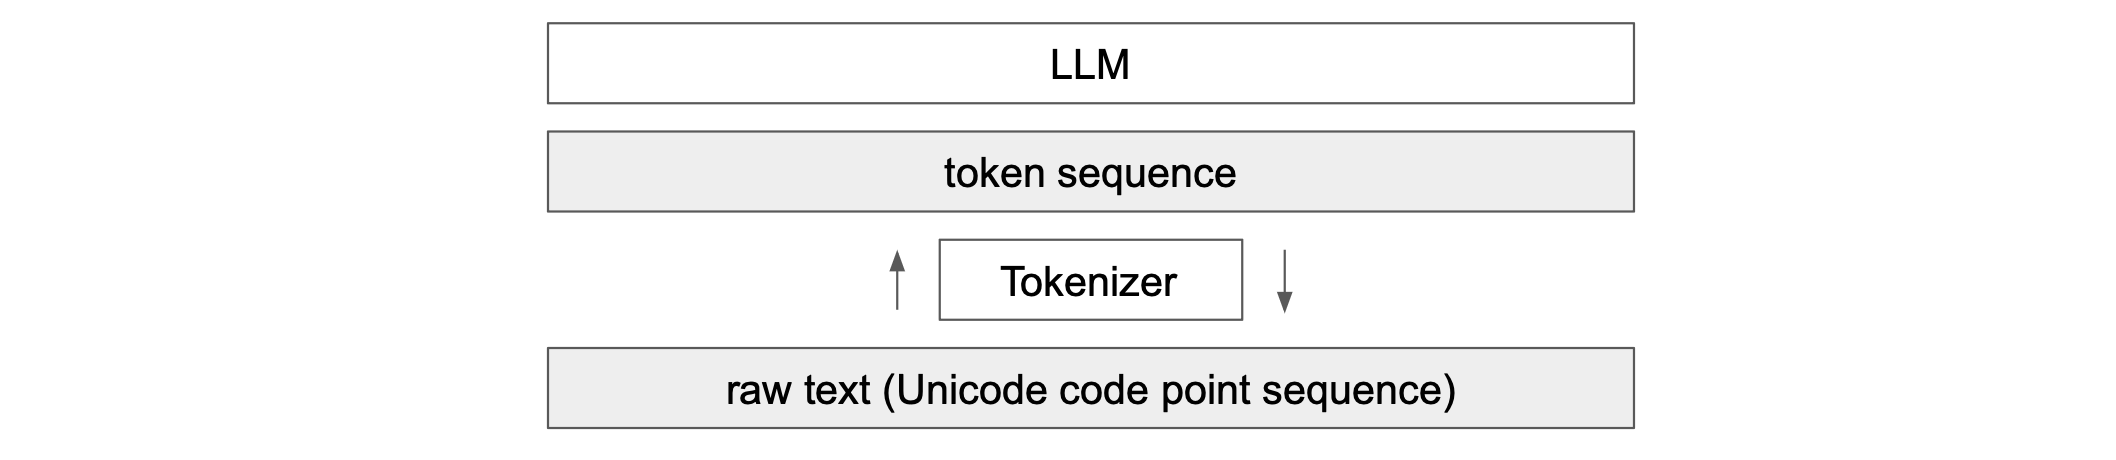

### decoding

> Given a sequence of integers in the range [0, vocab_size], what is the text?

Now we'll begin writing the decoder, which will take a sequence of tokens and convert them back into bytes.

In [63]:
# byte/list addition: byte([p0]) + byte([p1]) = byte([p0, p1])
b1 = bytes([1])
b2 = bytes([2])
b3 = b1 + b2
print(b1)
print(b2)
print(b3)

b'\x01'
b'\x02'
b'\x01\x02'


First we create a vocab mapping from and integer index to its respective byte based on the original 0 to 255 encodings

Next, we add the additional byte pair encoding stored in the  `merge` dictionary. This ensures that we get the new tokens, like (101, 32) -> 256. We add these new token indexes in the order they were created by the BPE algorithm above so that we don't overwrite earlier token mappings.

In [64]:
# map each index to its respective byte (convert list [idx] to a byte)
vocab = {idx: bytes([idx]) for idx in range(256)}
for (p0, p1), idx in merges.items():
    # byte/list addition: byte([p0]) + byte([p1]) = byte([p0, p1])
    vocab[idx] = vocab[p0] + vocab[p1] 

Now we write the decoder, which concatenates the bytes into a byte string. 

In [65]:
def decode(ids: list[int]) -> str:
    """given ids (list of integers), return Python string"""
    tokens = b"".join(vocab[idx] for idx in ids)
    text = tokens.decode("utf-8", errors="replace")
    return text

Importantly, we must set `errors="replace"` to handle cases like decoding 128, whose binary representation does not conform with [UTF-8 standards](https://en.wikipedia.org/wiki/UTF-8#Encoding). In these cases, we simply replace the output with the error character �. By [default](https://docs.python.org/3/library/codecs.html), `errors="strict"`, meaning that the code will throw an error when run.

For example, the binary representation of the byte 128 is 10000000 (2^7). However, the UTF-8 schema does not allow for the sequence 10xxxxx, where we start with 1 an 0, followed by the 6 remaining values. But the byte 101, which in binary is 01100101, does follow the format 0xxxxxx, and can be properly decoded.

In [66]:
print(decode([128])) # binary: 10000000
print(decode([101])) # binary: 01100101

�
e


### encoding

> The other way around: Given a string, what are the tokens?

And the encoder, which turns a string into a sequence of tokens

In [67]:
def encode(text: str) -> list[int]:
    """given a string, return a list of integers (the tokens)"""
    tokens = list(text.encode("utf-8"))

    # check if at least two tokens to cover cases like encode("h") where there are no pairs to merge!
    while len(tokens) >= 2:
        # get mapping of pairs to counts (int, int) -> count (int)
        stats = get_stats(ids)             

        # we want to work our way up the dictionary from first merged to last merged
        # so we need to get the byte pair merger with the lowest index 
        # merges has items (child, child) -> parent (int)
        # the key says to get the pair (child, child) with the smallest parent idx (int) -- added earliest
        # if the pair is not found within the merges dict, it outputs inf, which is definitely not the min in the generated list
        pair = min(stats, key=lambda p: merges.get(p, float("inf"))) 
        
        # if all pairs are not in merges, then they all return inf above, which is the min
        # then pair will become the first element in stats, which is still not in merges
        # at this point, we have merged all possible pairs into idxs, meaning that we can stop
        if pair not in merges:
            break 

        # otherwise, get the token representing the pair, merge it (replace in tokens), and continue
        idx = merges[pair]
        tokens = merge(tokens, pair, idx)
    return tokens


print(encode("hello world!"))

[104, 101, 108, 108, 111, 32, 119, 111, 114, 108, 100, 33]


Now that we have encoder and decoder, we better be able to cancel them out to get the original input back! 

Note that not all token sequences are valid byte strings, so we may encounter a decoder error where we get � (but should work fine in a lot of cases)

In [68]:
print(decode(encode("hello world!")))

hello world!


Ensure that the training text works too

In [69]:
text2 = decode(encode(text))
print(text2 == text)

True


And some validation data that the tokenizer was not trained on

In [70]:
valtext = "Many common characters, including numerals, punctuation, and other symbols, are unified within the standard and are not treated as specific to any given writing system. Unicode encodes thousands of emoji, with the continued development thereof conducted by the Consortium as a part of the standard.[4] Moreover, the widespread adoption of Unicode was in large part responsible for the initial popularization of emoji outside of Japan. Unicode is ultimately capable of encoding more than 1.1 million characters."
valtext2 = decode(encode(valtext))
print(valtext2 == valtext)

True


---
## 4) Regex

---

One of the problems with this sort of encoding is that it creates repetitious tokens like "dog", "dog.", "dog?", "dog!". It feels wrong that there should be tokens representing every word + punctuation combination, and this was determined to perform suboptimally in the [GPT-2 paper](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf) (2.2. Input Representation) (it wastes vocabulary slots and does not perform well empirically).

To address cases like these, they used regex patterns to enforce rules about which parts of the text will never be merged. 

Here's a Unicode regex [reference](https://www.regular-expressions.info/unicode.html).

In [71]:
import regex as re

### GPT-2 regex pattern in action

We can copy the GPT-2 regex pattern from its [GitHub repo](https://github.com/openai/gpt-2/blob/master/src/encoder.py#L53).

Some takeaways:

- lots of ORs "|"

In [72]:
gpt2pat = re.compile(r"""'s|'t|'re|'ve|'m|'ll|'d| ?\p{L}+| ?\p{N}+| ?[^\s\p{L}\p{N}]+|\s+(?!\S)|\s+""")

Let's test it out with a string. `re.findall()` will try to match patterns from left to right within the string, and store all of the matches in a list.

So for "Hello world", it will start at the left of `gpt2pat`, moving right, and find that it never matches `'s|'t|'re|'ve|'m|'ll|'d|`. Then it will find its first match at `| ?\p{L}+|`, an optional space " ?" followed by "\p{L}+" one or more times. According to the regex reference above, 

> \p{L} or \p{Letter}: any kind of letter from any language

So " ?\p{L}+" means an optional space followed by one or more letters from any language. 

Then for the string "Hello world", "Hello" will match the pattern (optional space (none) followed by letters). The match ends after "Hello", since the whitespace " " is not a letter. 

From there on, the pattern will attempt to match all `'s|'t|'re|'ve|'m|'ll|'d|` again, will fail, and then match `| ?\p{L}+|` with " world" (optional space (one) followed by letters).

In [73]:
re.findall(gpt2pat, "Hello world how are you")

['Hello', ' world', ' how', ' are', ' you']

The idea here is that we now *first* split the text into a list of texts. *Then* we tokenize these individual pieces independently.

This means that we can only ever find merges using BPE between the elements of this list. After we've found all of our merges, we join the results via concatenation. So in the list

```py
['Hello', ' world', ' how', ' are', ' you']
```

we will never merge " are" and " you", meaning we will never merge "e" with the whitespace " ". Wow! Recall that in the text above, the most frequent char pairing, and thus the first to be merged, was exactly that: "e" followed by a space " "!

Now that we've seen a simple example, let's brave our way through the whole pattern

```py
            gpt2pat = re.compile(r"""'s|'t|'re|'ve|'m|'ll|'d| ?\p{L}+| ?\p{N}+| ?[^\s\p{L}\p{N}]+|\s+(?!\S)|\s+""")
```

The patterns that are attempted to be matched in the order: 
1) `'s|'t|'re|'ve|'m|'ll|'d`  -- checks for the use of an apostrophe before these characters (common contractions, possessive case, etc) 
    - fails for Unicode apostrophe "how`s" instead of "how's"
    - does not use `re.IGNORECASE`, so will fail for uppercase variants like "how'S" or "that'LL"
2) `| ?\p{L}+|` -- checks for an optional space followed by one or more characters from any language
3) `| ?\p{N}+|` -- checks for an optional space followed by one or more numeric character in any script
4) `| ?[^\s\p{L}\p{N}]+|` -- checks for optional space followed by something that is not (^) a space (\s), a letter (\p{L}) or a number (\p{N})
    - checks for punctuation like  "what?!?!?!" -> " what" + "?!?!?!"
5) `\s+(?!\S)` -- uses negative lookahead assertion to match up to, but not the last, whitespace character (one or more spaces followed by a non-space)
    - separates "    y" where we have 4 whitespaces into "   " (3 spaces) and " y" (1 spaces)
6) `\s+` -- checks for one or more whitespace character
    - the last fallback pattern, useful when there are lots of spaces at the end, not followed by anything like in pattern (5)

We can manipulate our string to show each case

In [74]:
print(re.findall(gpt2pat, "Hello've world123 how`s are          ya'LL WHAT?!?!?!        "))

['Hello', "'ve", ' world', '123', ' how', '`', 's', ' are', '         ', ' ya', "'", 'LL', ' WHAT', '?!?!?!', '        ']


And now a real-world example. We see that there is a split at each "category" change.

In [75]:
example = """
for i in range(1, 101):
    if i % 3 == 0 and i % 5 == 0:
        print("FizzBuzz")
    elif i % 3 == 0:
        print("Fizz")
    elif i % 5 == 0:
        print("Buzz")
    else:
        print(i)
"""
print(re.findall(gpt2pat, example))

['\n', 'for', ' i', ' in', ' range', '(', '1', ',', ' 101', '):', '\n   ', ' if', ' i', ' %', ' 3', ' ==', ' 0', ' and', ' i', ' %', ' 5', ' ==', ' 0', ':', '\n       ', ' print', '("', 'FizzBuzz', '")', '\n   ', ' elif', ' i', ' %', ' 3', ' ==', ' 0', ':', '\n       ', ' print', '("', 'Fizz', '")', '\n   ', ' elif', ' i', ' %', ' 5', ' ==', ' 0', ':', '\n       ', ' print', '("', 'Buzz', '")', '\n   ', ' else', ':', '\n       ', ' print', '(', 'i', ')', '\n']


So you'd think that OpenAI would've then trained the tokenizer by splitting training text into chunks based on the above regex pattern and then using BPE. However, this is not the case. Why? Well, above in the code example, we see a chunk "\n       " consisting of a newline char and whitespace (the indent before a line of code). But using the GPT-2 tokenizer, we find that the spaces are actually never merged. Instead, tokenizing a chunk like this reveals a series of individual space tokens. So "  " would be tokenized into [220, 220], two whitespace tokens. So somewhere in the tokenizer training file there is an additional rule enforcing that spaces are never merged. However, this tokenizer training file has not been made publically available, so we can't see exactly what they did. We can, however, use the open source inference tokenizer, provided to us by the `tiktoken` package (or in the GPT-2 [GitHub repo](https://github.com/openai/gpt-2/blob/master/src/encoder.py)), which applies the trained merges (learned through BPE in the training code) to a new piece of text.

In [76]:
import tiktoken

We can see below that the GPT-2 tokenizer treats the two whitespace characters as two separate tokens, denoted by the two 220 tokens. The GPT-4 tokenizer merges the spaces into a single token.

In [77]:
# GPT-2 does not merge spaces 
enc = tiktoken.get_encoding("gpt2")
print(enc.encode("   hello world!!!"))

# GPT-4 does merge spaces
enc = tiktoken.get_encoding("cl100k_base")
print(enc.encode("   hello world!!!"))

[220, 220, 23748, 995, 10185]
[256, 24748, 1917, 12340]


The GPT-4 tokenizer uses a different regex pattern. The regex patterns for all of the tokenizers can be found in the [tiktoken repo](https://github.com/openai/tiktoken/blob/main/tiktoken_ext/openai_public.py). The GPT-4 tokenizer, cl100k_base, has the regex pattern

```py
            gpt4pat = re.compile(r"""'(?i:[sdmt]|ll|ve|re)|[^\r\n\p{L}\p{N}]?+\p{L}+|\p{N}{1,3}| ?[^\s\p{L}\p{N}]++[\r\n]*|\s*[\r\n]|\s+(?!\S)|\s+""")
```

Key points:

1) `?i:[sdmt]|ll|ve|re)` -- the i denotes a case insensitive match, fixing the apostrophe matching problem from the GPT-2 tokenizer
2) a lot more whitespace handling
3) `\p{N}{1,3}` -- they only match 1 to 3 numbers -- never merge numbers that are more than three digits
    - this means that numbers 1, 2, or 3 digits long are subject to be merged into single tokens. so something like "12345" may be tokenized into ["123", "45"]

---
## 5) Walking through the GPT-2 tokenizer

---

At this point, we have enough knowledge to start dissecting the GPT-2 tokenizer [encoder.py](https://github.com/openai/gpt-2/blob/master/src/encoder.py). Note that while the file and class are called encoders, it is really a tokenizer!

We see that in `get_encoder()`, it instantiates a new `Encoder` object (tokenizer) using encoder.json and vocab.bpe. We can download these files to get an idea of what they store.

In [78]:
# to download these files:
# !wget https://openaipublic.blob.core.windows.net/gpt-2/models/1558M/vocab.bpe
# !wget https://openaipublic.blob.core.windows.net/gpt-2/models/1558M/encoder.json

It turns out that [encoder.json](encoder.json) is equivalent to our `vocab` dictionary above, meaning our mappings from ints to bytes

```py
    {
      "0": "b'\x00'",
      "1": "b'\x01'",
      "2": "b'\x02'",
      "3": "b'\x03'", 
    }
```

except that it actually maps the inverse: byte to int.

[vocab.bpe](vocab.bpe) is equivalent to our `merges` dictionary above, meaning our mappings from pairs of tokens to

```py
    {
      (101, 32): 256,
      (105, 110): 257,
      (115, 32): 258,
      (116, 104): 259
    }
```

In [79]:
import os, json

with open("encoder.json", "r") as f:
    encoder = json.load(f) # <--- ~equivalent to our "vocab"


with open("vocab.bpe", "r", encoding="utf-8") as f:
    bpe_data = f.read()
bpe_merges = [tuple(merge_str.split()) for merge_str in bpe_data.split("\n")[1:-1]]
# ^---- ~equivalent to our "merges"

In addition to an `encoder` and `decoder`, the GPT-2 `Encoder` class also has a `byte_encoder` and `byte_decoder`. This just splits up the process a bit more: byte encode (Unicode code points to byte stream) -> encode (byte stream to tokens) -> decode (tokens to byte stream) -> byte decode (byte stream to code points).

---
## 6) Special tokens

---

In addition to the tokens from raw bytes and BPE merges, we can also use special tokens to delimit different parts of the data and create special structures in the token strings.

The length of the GPT-2 `encoder` dictionary (bytes to int ids) is 50257. Where does this number come from?

1) 256 raw byte tokens (1 byte == 8 bits --> 256 possible values with indexes ranging from 0 to 255)
2) 50,000 tokens from BPE merges
3) 1 special token "<|endoftext|>"

In [80]:
len(encoder)

50257

In [81]:
[(k, v) for k, v in encoder.items()][:10]

[('!', 0),
 ('"', 1),
 ('#', 2),
 ('$', 3),
 ('%', 4),
 ('&', 5),
 ("'", 6),
 ('(', 7),
 (')', 8),
 ('*', 9)]

We can see that this special "<|endoftext|>" token is at the very end of the list. 

It's used to delimit documents in the training set. When we tokenize the training set, we'll get a string of tokens from 0 to 50256. The "<|endoftext|>" token is inserted
between documents to indicate that what follows is going to be unrelated / not informative to what comes next. 

By including these tokens, we hope to teach the language model through data to "wipe its memory" of what came before the "<|endoftext|>" token when encountered.

In [82]:
encoder["<|endoftext|>"]

50256

If we use [https://tiktokenizer.vercel.app](https://tiktokenizer.vercel.app), we see that as we type "<|endoftext|>", it breaks it down into multiple tokens until the full string is typed, at which point it becomes a single token.

In [88]:
# GPT-4 
enc = tiktoken.get_encoding("cl100k_base")
print(enc.encode("<|endoftext|")) # not the full <|endoftext|> token -- so broken up into tokens

[27, 91, 8862, 728, 428, 91]


Okay, so 
- Why does this work? 
- How does the string of tokens we see above change to a single token upon typing the final character? 
- Why is "<|endoftext|>" called a special token?

Well, these so-called special tokens do not go through the BPE merge algorithm. Instead, the code has special instructions to locate and handle special tokens. 

For example, in the [tiktoken repo](https://github.com/openai/tiktoken/blob/main/src/lib.rs#L210) we see that special tokens are found outside of the BPE algorithm


```rs
        loop {
            // Find the next allowed special token, if any
            next_special = special_regex.find_from_pos(text, start_find).unwrap();
            match next_special {
                Some(m) => {
                    if allowed_special.contains(&text[m.start()..m.end()]) {
                        break;
                    }
                    start_find = m.start() + 1;
                }
                None => break,
            }
        }
```

The rest of the code then replaces the stream of tokens with the single special token.

Special tokens are used everywhere, especially in instruction/chat finetuning. This is because we don't want to just delimit documents, we also want to delimit conversations between an assistant and a user. Some other examples include "<|im_start|>", "<|im_sep|>", "<|im_end|>", etc.

```text
    <|im_start|>system<|im_sep|>You are a helpful assistant<|im_end|>
    <|im_start|>user<|im_sep|><|im_end|>
    <|im_start|>assistant<|im_sep|>
```

These special tokens are arbitrary and can be added to tokenizers, as long as they are handled.

GPT-4 also has special `FIM_PREFIX`, `FIM_MIDDLE`, `FIM_SUFFIX` tokens (fill in the middle) that supposedly [help](https://arxiv.org/pdf/2207.14255) train the model.

When you add special tokens, however, you have to do some model surgery to the transformer and its parameters.

By adding a special token, we're sort of extending the vocabulary. As such, we need to create a new row in the embedding matrix and include another neuron in 
the final projection layer, both to stand in for the special token.

---
## 7) GPT-4 tokenizer exercise

---

At this point, we'll follow along this [exercise](https://github.com/karpathy/minbpe/blob/master/exercise.md) to implement the GPT-4 tokenizer.

### Step 1

Write the `BasicTokenizer` class, with the following three core functions:

- `def train(self, text, vocab_size, verbose=False)`
- `def encode(self, text)`
- `def decode(self, ids)`

Train your tokenizer on whatever text you like and visualize the merged tokens. Do they look reasonable? One default test you may wish to use is the text file `tests/taylorswift.txt`.


In [89]:
def get_stats(ids: list[int], counts: dict = None) -> dict[tuple[int, int], int]:
    """
    Given a list of integers, return a dictionary of counts of consecutive pairs
    Example: [1, 2, 3, 1, 2] -> {(1, 2): 2, (2, 3): 1, (3, 1): 1}
    Optionally allows to update an existing dictionary of counts
    """
    counts = {} if counts is None else counts
    for pair in zip(ids, ids[1:]): 
        counts[pair] = counts.get(pair, 0) + 1
    return counts


def merge(ids: list[int], pair: tuple[int, int], idx: int) -> list[int]:
    """
    In the list of integers (ids), replace all consecutive occurrences
    of pair with the new integer token idx
    Example: ids=[1, 2, 3, 1, 2], pair=(1, 2), idx=4 -> [4, 3, 4]
    """
    newids = []
    i = 0
    while i < len(ids):
        # if not at the very last position AND the pair matches, replace it
        if ids[i] == pair[0] and i < len(ids) - 1 and ids[i+1] == pair[1]:
            newids.append(idx)
            i += 2
        # otherwise, only proceed one step to check next pair
        else:
            newids.append(ids[i])
            i += 1
    return newids

In [ ]:
class BasicTokenizer:
    def __init__(self, ):
        # default: vocab size of 256 (all bytes), no merges, no patterns
        self.merges: dict[tuple[int, int], int] = {}  # (int, int) -> int
        self.pattern: str = "" 
        self.special_tokens: dict[str, int] = {}  # str -> int, e.g. {'<|endoftext|>': 100257}
        self.vocab: dict[int, bytes] = self._build_vocab()  # int -> bytes

    def train(self, text: str, vocab_size: int, verbose: bool = False):
        assert vocab_size > 256
        num_merges = vocab_size - 256

        for i in range(num_merges):
            stats = get_stats()

    def encode(self, text: str) -> list[int]:
        ...
    
    def decode(self, ids: list[int]) -> str:
        ...

### Step 2

Convert you `BasicTokenizer` into a `RegexTokenizer`, which takes a regex pattern and splits the text exactly as GPT-4 would. Process the parts separately as before, then concatenate the results. Retrain your tokenizer and compare the results before and after. You should see that you will now have no tokens that go across categories (numbers, letters, punctuation, more than one whitespace). Use the GPT-4 pattern:

```
GPT4_SPLIT_PATTERN = r"""'(?i:[sdmt]|ll|ve|re)|[^\r\n\p{L}\p{N}]?+\p{L}+|\p{N}{1,3}| ?[^\s\p{L}\p{N}]++[\r\n]*|\s*[\r\n]|\s+(?!\S)|\s+"""
```

### Step 3

You're now ready to load the merges from the GPT-4 tokenizer and show that your tokenizer produces the identical results for both `encode` and `decode`, matching [tiktoken](https://github.com/openai/tiktoken).

```
# match this
import tiktoken
enc = tiktoken.get_encoding("cl100k_base") # this is the GPT-4 tokenizer
ids = enc.encode("hello world!!!? (안녕하세요!) lol123 😉")
text = enc.decode(ids) # get the same text back
```

Unfortunately, you will run into two issues:

1. It is not trivial to recover the raw merges from the GPT-4 tokenizer. You can easily recover what we call `vocab` here, and what they call and store under `enc._mergeable_ranks`. Feel free to copy paste the `recover_merges` function in `minbpe/gpt4.py`, which takes these ranks and returns the raw merges. If you wish to know how this function works, read [this](https://github.com/openai/tiktoken/issues/60) and [this](https://github.com/karpathy/minbpe/issues/11#issuecomment-1950805306). Basically, under some conditions it is enough to only store the parent nodes (and their rank) and get rid of the precise details of which children merged up to any parent.
2. Second, the GPT-4 tokenizer for some reason permutes its raw bytes. It stores this permutation in the first 256 elements of the mergeable ranks, so you can recover this byte shuffle relatively simply as `byte_shuffle = {i: enc._mergeable_ranks[bytes([i])] for i in range(256)}`. In both your encode and decode, you'll have to shuffle bytes around accordingly. If you're stuck, reference the minbpe/gpt4.py` file for hints.


### Step 4

(Optional, irritating, not obviously useful) Add the ability to handle special tokens. You'll then be able to match the output of tiktoken even when special tokens are present, e.g.:

```
import tiktoken
enc = tiktoken.get_encoding("cl100k_base") # this is the GPT-4 tokenizer
ids = enc.encode("<|endoftext|>hello world", allowed_special="all")
```

Without `allowed_special` tiktoken will error.

Let's test the tokenizer out!

In [ ]:
import tiktoken
enc = tiktoken.get_encoding("cl100k_base") # GPT-4 tokenizer
print(enc.encode("안녕하세요 👋 (hello in Korean!)"))
print(enc.decode(enc.encode("안녕하세요 👋 (hello in Korean!)")) == "안녕하세요 👋 (hello in Korean!)")
# match the above for your own tokenizer, and also implement a train() function

### Step 5

If you've made it this far, you're now a pro at LLM Tokenization! Sadly, you're not exactly done yet because a lot of LLMs outside of OpenAI (e.g. Llama, Mistral) use [sentencepiece](https://github.com/google/sentencepiece) instead. Primary difference being that sentencepiece runs BPE directly on Unicode code points instead of on UTF-8 encoded bytes. Feel free to explore sentencepiece on your own (good luck, it's not too pretty), and stretch goal if you really experience and suffer from the burden of time, re-write your BPE to be on Unicode code points and match the Llama 2 tokenizer.

---
## 8) Sentencepiece

---

Commonly used because (unlike tiktoken) it can efficiently both train and inference BPE tokenizers. It is used in both Llama and Mistral series.

[sentencepiece on Github link](https://github.com/google/sentencepiece).

**The big difference**: sentencepiece runs BPE on the Unicode code points directly! It then has an option `character_coverage` for what to do with very very rare codepoints that appear very few times, and it either maps them onto an UNK token, or if `byte_fallback` is turned on, it encodes them with utf-8 and then encodes the raw bytes instead.

TLDR:

- tiktoken encodes to utf-8 and then BPEs bytes
- sentencepiece BPEs the code points and optionally falls back to utf-8 bytes for rare code points (rarity is determined by character_coverage hyperparameter), which then get translated to byte tokens.


In [ ]:
import sentencepiece as spm

In [ ]:
# write a toy.txt file with some random text
with open("toy.txt", "w", encoding="utf-8") as f:
  f.write("SentencePiece is an unsupervised text tokenizer and detokenizer mainly for Neural Network-based text generation systems where the vocabulary size is predetermined prior to the neural model training. SentencePiece implements subword units (e.g., byte-pair-encoding (BPE) [Sennrich et al.]) and unigram language model [Kudo.]) with the extension of direct training from raw sentences. SentencePiece allows us to make a purely end-to-end system that does not depend on language-specific pre/postprocessing.")